# Introduction to FlowDirectors

Landlab directs flow and accumulates it using two types of components:

**FlowDirectors** use the topography to determine how flow moves between adjacent nodes. For every node in the grid it determines the nodes to receive flow and the proportion of flow to send from one node to its receiver. 

The **FlowAccumulator** uses the direction and proportion of flow moving between each node and (optionally) water runoff to calculate drainage area and discharge. 

The **FlowDirectors** are method-specific, and presently landlab supports four different methods for determining flow direction. 

1. **FlowDirectorSteepest** Flow is routed to only one node. The algorithm considers the link slopes leaving from each node and chooses the steepest downhill link to route flow along. In the case of a raster grid, only the links are considered (Landlab differentiates between *links*, which never cross and are located at North, South, East, and West on a raster grid, and *diagonals*, which cross and are located at North East, North West, South East, and South West). For raster grids, this method is also known as D4 flow routing. In the case of irregular grids, all links originating from a node are consideded.

2. **FlowDirectorD8** (raster only) Flow is only routed to one node but diagonals are also considered. 

3. **FlowDirectorMFD** Flow is directed to all nodes that are located downhill of the source node. In the case of raster grid diagonals can be included using the keyword ```diagonals=True```. Flow is partitioned between receiver nodes based on the relative slope along the links leading to the receiver nodes. The default method for partitioning is based on the sum of receiver slopes (```partition_method='slope'```). Partitioning can also be done on the basis of the square root of slope which gives the result of a steady kinematic wave (```partition_method='square_root_of_slope'```).

4. **FlowDirectorDINF** (raster only) Flow is directed to two cells based on the slope of the triangular facets that can be defined between a node and its neighbors. The steepest downhill facet is chosen and then flow is partitioned between the receiver nodes at the bottom of that facet based on the relative slopes along the facet-bounding links. (The method, known as "D-infinity", is described by Tarboton (1997, Water Resources Research, 33(2), 309-319)).

In this tutorial we will go over how to initialize and run a **FlowDirector**, and briefly compare the different flow direction algorithms. For information on how to initialize and run the **FlowAccumulator** or more detailed examples that contrast the differences between each flow direction algorithm, refer to the other tutorials in this section. 

First, we import the necessary Python modules and make a small plotting routine. 

In [1]:
%matplotlib inline

In [2]:
# import plotting tools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib as mpl

# import numpy
import numpy as np

# import necessary landlab components
from landlab import RasterModelGrid, HexModelGrid
from landlab.components import(FlowDirectorD8, 
                               FlowDirectorDINF, 
                               FlowDirectorMFD, 
                               FlowDirectorSteepest)

# import landlab plotting functionality
from landlab.plot.drainage_plot import drainage_plot

# create a plotting routine to make a 3d plot of our surface. 
def surf_plot(mg, surface='topographic__elevation', title='Surface plot of topography'):
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Plot the surface.
    Z = mg.at_node[surface].reshape(mg.shape)
    color = cm.gray((Z-Z.min())/(Z.max()-Z.min()))
    surf = ax.plot_surface(mg.x_of_node.reshape(mg.shape), mg.y_of_node.reshape(mg.shape), 
                           Z,
                           rstride=1, cstride=1,
                           facecolors=color,
                           linewidth=0., 
                           antialiased=False)
    ax.view_init(elev=35, azim=-120)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Elevation')
    plt.title(title)
    plt.show()

## Topographic grid

For this tutorial we will consider one topographic surface. A separate tutorial exists that compares multiple grids and highlights the difference in flow direction and accumulation between the different methods. 

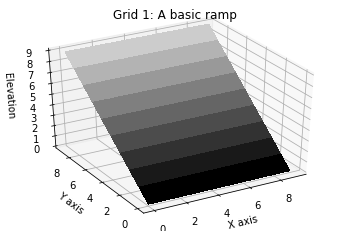

In [3]:
mg1 = RasterModelGrid((10,10), spacing=(1, 1))
_ = mg1.add_field('topographic__elevation',
                  mg1.y_of_node,
                  at = 'node')
surf_plot(mg1, title='Grid 1: A basic ramp')

# Initalizing and running a FlowDirector

To instantiate a flow director, you must pass it the minimum of a model grid that has a field called ```'topographic__elevation'```. Alternatively, you can pass it the name of another field name at node, or an array with length number of nodes. 



In [4]:
fd = FlowDirectorSteepest(mg1, 'topographic__elevation')

The **FlowDirectors** are method specific, so if you want to do D8 flow directing, you must use **FlowDirectorD8**.

All of the **FlowDirectors** have two public methods: ```run_one_step()``` and ```direct_flow()```.

Both use the values of the surface provided to identify flow directions (and in the case of directing to more than one receiver, proportions). Both store the same information about receivers, proportions, and other calculated values to the model grid as fields. The difference is that ```run_one_step()``` does not return any values while ```direct_flow()``` returns the receiver array in **FlowDirectorSteepest** and **FlowDirectorD8**, and the receiver and proportion arrays in **FlowDirectorMFD** and **FlowDirectorDINF**. 

In [5]:
fd.run_one_step()

receivers = fd.direct_flow()

print(receivers)

[ 0  1  2  3  4  5  6  7  8  9 10  1  2  3  4  5  6  7  8 19 20 11 12 13 14
 15 16 17 18 29 30 21 22 23 24 25 26 27 28 39 40 31 32 33 34 35 36 37 38 49
 50 41 42 43 44 45 46 47 48 59 60 51 52 53 54 55 56 57 58 69 70 61 62 63 64
 65 66 67 68 79 80 71 72 73 74 75 76 77 78 89 90 91 92 93 94 95 96 97 98 99]


We can illustrate the receiver node **FlowDirectionSteepest** has assigned to each donor node using a plotting function in Landlab called ```drainage_plot```. We will see many of these plots in this tutorial so let's take a moment to walk through the plot and what it contains. 

- The background image (white to black) shows the values of topographic elevation of the underlying surface or any other at_node field we choose to plot.

- The colors of the dots inside of each pixel show the locations of the nodes and the type of node. 

- The arrows show the direction of flow, and the color shows the proportion of flow that travels along that link. 

- The X on top of a node shows indicates that the node is a local sink and flows to itself. 

Note that in Landlab *Boundary Nodes*, or nodes that are on the edge of a grid, do not have area and do not contribute flow to nodes. These nodes can either be *Fixed Gradient Nodes*, *Fixed Value Nodes*, or *Closed Nodes*. With the exception of *Closed Nodes* the boundary nodes can receive flow. 

An important step in all flow direction and accumulation is setting the proper boundary condition. Refer to the boundary condition tutorials for more information. 

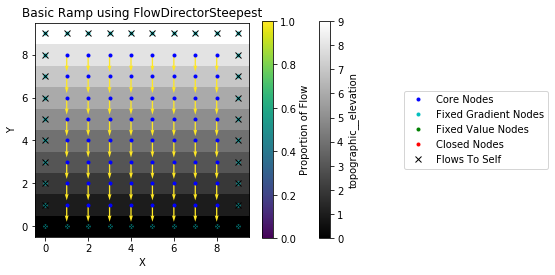

In [6]:
plt.figure()
drainage_plot(mg1, title='Basic Ramp using FlowDirectorSteepest')

Reassuringly we can see that the flow is being sent from high elevations at the top of the grid to low elevations at the bottom of the grid. We can also see that all of the arrows are yellow, and thus all of the flow is traveling on these links. 

# Brief Comparison between FlowDirector methods

Now let's see how the other **FlowDirectors** direct the flow on this simple grid. We don't need to specify the surface so long as it is the field ```'topographic__elevation'```.

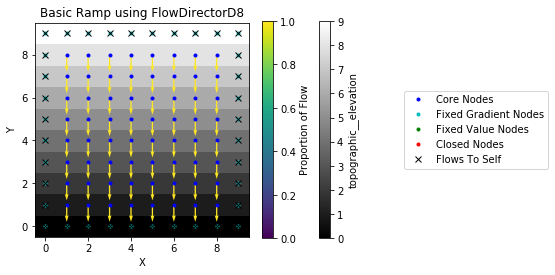

In [7]:
fd = FlowDirectorD8(mg1)
fd.run_one_step()
plt.figure()
drainage_plot(mg1, title='Basic Ramp using FlowDirectorD8')

For this ramp, the steepest slope is down a link, and not a diagonal, so **FlowDirectorD8** gives the same result as **FlowDirectorSteepest**.

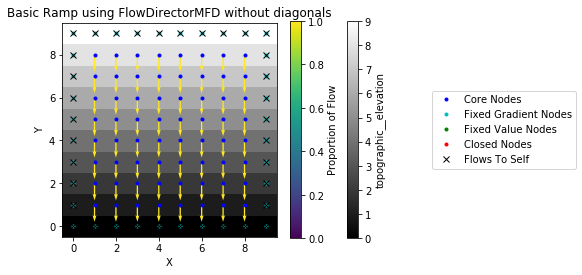

In [8]:
fd = FlowDirectorMFD(mg1, diagonals=False) # diagonals=False is the default option
fd.run_one_step()
plt.figure()
drainage_plot(mg1, title='Basic Ramp using FlowDirectorMFD without diagonals')

Similarly, while there is more than one node below each core node, there is only one node that is connected by a link and not a diagonal. Thus **FlowDirectorMFD** with the keyword ```diagonals``` set to ```True``` provides the same results as **FlowDirectorSteepest** and **FlowDirectorD8**

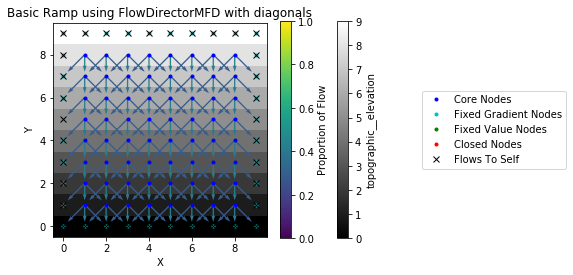

In [9]:
fd = FlowDirectorMFD(mg1, diagonals=True)
fd.run_one_step()
plt.figure()
drainage_plot(mg1, title='Basic Ramp using FlowDirectorMFD with diagonals')

When we permit flow along diagonal connections between nodes and flow to all downhill nodes, we see a difference in the directing pattern on this simple ramp. The flow is partitioned between the three downhill nodes, and there is more flow being sent to along the link as compared with the diagonals (the links are a lighter color blue than the diagonals). We can print out the proportion of flow, which is stored as a (number of nodes, number of possible receivers) array for **FlowDirectorMFD**. We will just print one node for clarity. The order of the receivers is in line with the standard Landlab ordering. The array will list the receiver proportions in the following order:

    [link to East,
    link to North,
    link to West,
    link to South,
    diagonal to North East,
    diagonal to North West,
    diagonal to South West,
    diagonal to South East]

In [10]:
print(mg1.at_node['flow__receiver_proportions'][15])

[ 0.          0.          0.          0.41421356  0.          0.
  0.29289322  0.29289322]


As we can see, the flow is moving on the link to the South, the South West and South East. There is about a third of the flow moving on the links and diagonals, though more flow is partitioned to the link. This makes sense as the link is steeper than the diagonals. 

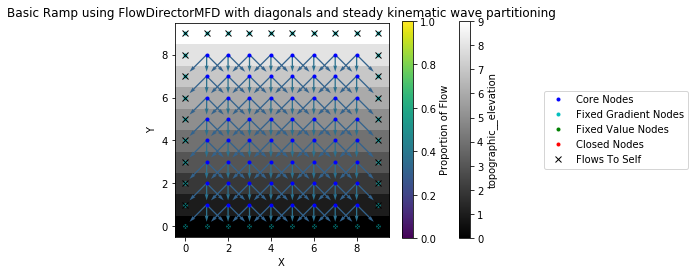

In [11]:
fd = FlowDirectorMFD(mg1, diagonals=True, partition_method='square_root_of_slope')
fd.run_one_step()
plt.figure()
drainage_plot(mg1, title='Basic Ramp using FlowDirectorMFD with diagonals and steady kinematic wave partitioning')

In the **FlowDirectorMFD** we can partition flow based on slope (default) or based on the square root of the slope. This option gives the solution to a steady kinematic wave. We can see that the proportion of flow going on the links and diagonals is more similar. 

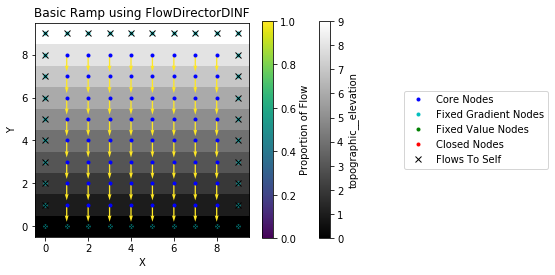

In [12]:
fd = FlowDirectorDINF(mg1)
fd.run_one_step()
plt.figure()
drainage_plot(mg1, title='Basic Ramp using FlowDirectorDINF')

In **FlowDirectorDINF** flow is partitioned to two nodes based on steepness of the eight triangular facets surrounding each node. The partitioning is based on the relation between the link and diagonal slope that form the edge of the facet and the slope of the facet itself. When one of the facet edges has the same slope as the facet, as is the case in this ramp example, all of the flow is partitioned along that edge. 

# FlowDirectors on irregular grids 

**FlowDirectorSteepest** and **FlowDirectorMFD** work on raster, hex, and irregular grids. **FlowDirectorD8** and **FlowDirectorDINF** don't work on hex or irregular grids because the directing and partitioning algorithm that underlies each of them is specific to raster grids. 

Before concluding this tutorial, we will briefly consider a hexagonal example. 

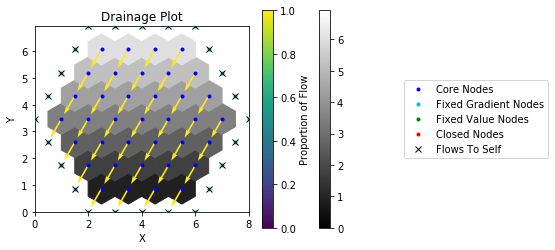

In [13]:
hmg = HexModelGrid(9,5)
_ = hmg.add_field('topographic__elevation', hmg.y_of_node, at = 'node')
fd=FlowDirectorSteepest(hmg)
fd.run_one_step()
plt.figure()
drainage_plot(hmg)

Just as in the raster example, **FlowDirectorSteepest** sends flow from donor nodes to only one receiver node. You may ask why the flow is going to the southwest while the links are just as steep to the southeast. When two links have exactly the same slope, in route-to-one methods like **FlowDirectorSteepest** and **FlowDirectorD8** landlab will choose the first steepest link it encounters while searching through the links. When diagonal links are also considered in **FlowDirectorD8** the diagonals are examined after the links. Thus if a link and a diagonal leading from one node downhill had exactly the same slope, the flow would be sent down the link. 

For a more thorough discussion and comparison of each of the **FlowDirector** algorithms, please see the tutorial "Comparison of FlowDirectors".

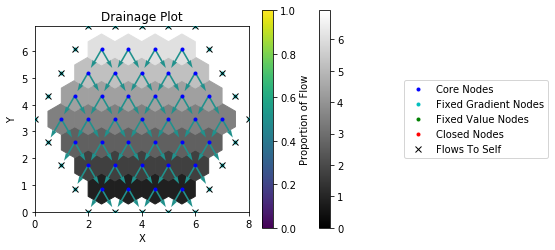

In [14]:
fd = FlowDirectorMFD(hmg)
fd.run_one_step()
plt.figure()
drainage_plot(hmg)

Using **FlowDirectorMFD** flow is partitioned equally between the two links leading downhill. 

# Conclusion

This tutorial went over the different **FlowDirectors** present in Landlab and how to create and run a **FlowDirector**. Next consider reviewing two additional tutorials about directing and accumulating flow in Landlab:

1. **Comparison of FlowDirectors**: A tutorial that contrasts the different methods in more detail and over surfaces that are more complicated than a simple sloping ramp. 

2. **Introduction to FlowAccumulator**: A tutorial that describes how to use the **FlowAccumulator**.